In [43]:
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
from numpy import array

import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [10]:
# Read in the json file as a python dict using photo_id as key
yelp_data = {}
with open('photos.json') as file:
    for line in file:
        cur_img = json.loads(line)
        yelp_data[cur_img['photo_id']] = cur_img

In [11]:
# Convert yelp_data into dataframe
df = pd.DataFrame.from_dict(yelp_data, 'index')
df.head()
# yelp_data

,caption,photo_id,business_id,label
---SnSf4OfUFfJmCxw1DZA,,---SnSf4OfUFfJmCxw1DZA,XQ0RIDqgnkXueL6y1CY3Cg,food
--0uqWanwN31OkuuwJ1zjQ,Le Gadboi: Poutine with pogos and onion rings.,--0uqWanwN31OkuuwJ1zjQ,XIg92ukZJn_1aiNx0OmusQ,food
--3gCyYz0Eo3r07tAvUbhg,Their OMAKASE is AMAZING!!!!! Very recommended,--3gCyYz0Eo3r07tAvUbhg,VeiL_tgw7dsl-7IcnOsh0g,food
--3vR19cePIkGQBgcLsQkw,Big steak omelette,--3vR19cePIkGQBgcLsQkw,If6Bku2jkgPiikR6HBu-XQ,food
--7InqXrxwFUY6-ePZILpQ,,--7InqXrxwFUY6-ePZILpQ,QJatAcxYgK1Zp9BRZMAx7g,food


In [12]:
df.groupby('label', as_index=False).agg({'business_id': 'count'}).rename(columns={'business_id': 'count'})

,label,count
0,drink,6620
1,food,132354
2,inside,47959
3,menu,894
4,outside,19122


In [144]:
# Get all the file names of photos
import os
cwd = os.getcwd()
train_photos = os.listdir(cwd + "/yelp_photos")
test_photos = os.listdir(cwd + "/yelp_test_photos")

In [145]:
# Convert images into a list of numpy arrays, and a list of integers
def read_image(all_photo_name, path):
    label_map = {0:"drink", 1: "food", 2: "inside", 3: "outside", 4: "menu"}
    np_labels = []
    np_imgs = []

    for p in all_photo_name:
        if (p != '.DS_Store'):
            data = plt.imread(path + p)
            image_resized = resize(data, (128, 128))
            image_reshaped = image_resized.transpose()
            np_imgs.append(image_reshaped)
            p_id = os.path.splitext(p)[0]
            if yelp_data[p_id]['label'] == 'drink':
                np_labels.append(0)
            elif yelp_data[p_id]['label'] == 'food':
                np_labels.append(1)
            elif yelp_data[p_id]['label'] == 'inside':
                np_labels.append(2)
            elif yelp_data[p_id]['label'] == 'outside':
                np_labels.append(3)
            else:
                np_labels.append(4)

    imgs_npy = np.array(np_imgs)
    label_npy = np.array(np_labels)
    
    return imgs_npy, label_npy

In [146]:
train_imgs_npy, train_label_npy = read_image(train_photos, 'yelp_photos/')
test_imgs_npy, test_label_npy = read_image(test_photos, 'yelp_test_photos/')

In [133]:
class Dataset(Dataset):
    def __init__(self, imgs_npy, label_npy, train=True, normalize=False):
        """
        """
        X = imgs_npy.astype(float)
        y = label_npy.astype(float)  
        print(X.shape)
        if normalize:
            for index, img in enumerate(X):
                img_mean = img.mean()
                img_std = img.std()
                img = (img - img_mean) / img_std
                X[index] = img
            
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).float()

    def __len__(self):
        
        return self.len

    def __getitem__(self, idx):
        
        return self.x_data[idx], self.y_data[idx]

In [150]:
# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy)
test_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

(800, 3, 128, 128)
(100, 3, 128, 128)


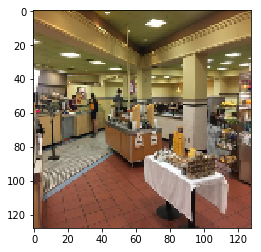

In [135]:
# Plot the resized first image in dataset
photos[1]

test_data = plt.imread('yelp_photos/' + photos[1])
resized_data = resize(test_data, (128, 128))

plt.imshow(resized_data)

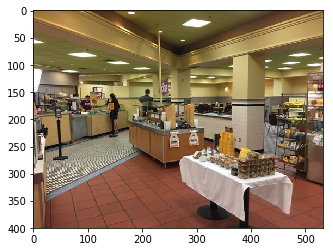

In [51]:
# Plot the original image
plt.imshow(test_data)

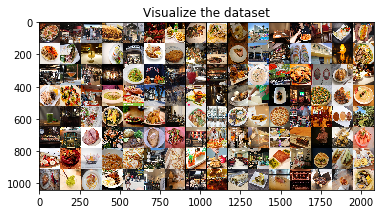

In [151]:
# # Visualize the dataset
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title('Visualize the dataset')
    plt.imshow(np.transpose(npimg))
#     plt.imshow(np.transpose(npimg, (1, 2, 0))/255)
    

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# plt.imshow(resized_data)


In [152]:
# Simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128*128*3, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = F.sigmoid(self.fc1(x))
        out = F.sigmoid(self.fc2(out))
        
        return out

In [153]:
def train_accuracy():
    # Specify the loss function
    criterion = nn.CrossEntropyLoss()

    # Specify the optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
#      Adagrad CNN structure
#     optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0)

    max_epochs = 10

    # loss_np = np.zeros((max_epochs))
    accuracy = np.zeros((max_epochs))

    for epoch in range(max_epochs):
        tot_correct = 0
        tot_len = 0
#         tot_loss = 0
        for i, data in enumerate(train_loader, 0):
            # Get inputs and labels from data loader 
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels).long()

            # Feed the input data into the network 
            y_pred = net(inputs)

            # Calculate the loss using predicted labels and ground truth labels
            loss = criterion(y_pred, labels)

            # zero gradient
            optimizer.zero_grad()

            # backpropogates to compute gradient
            loss.backward()

            # updates the weghts
            optimizer.step()

            # convert predicted laels into numpy
            y_pred_np = y_pred.data.numpy()

            # calculate the training accuracy of the current model
            pred_np = np.argmax(y_pred_np, axis=1)
            label_np = labels.data.numpy().reshape(len(labels),1)

            pred_np = pred_np.reshape(len(pred_np), 1)

            correct=0
            for j in range(y_pred_np.shape[0]):
                if pred_np[j,:] == label_np[j,:]:
                    correct += 1

            tot_len+=1
            tot_correct+= float(correct)/float(len(label_np))
#             tot_loss+= loss.data.numpy()

        accuracy[epoch] = float(tot_correct)/float(tot_len)
#         loss_np[epoch] = tot_loss / tot_len

    print("final training accuracy: ", accuracy[max_epochs-1])

    epoch_number = np.arange(0,max_epochs,1)

    # Plot the training accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, accuracy)
    plt.title('training accuracy over epoches')
    plt.xlabel('Number of Epoch')
    plt.ylabel('accuracy')

    # final training accuracy:  0.371516719745

In [154]:
def test_accuracy():
    tot_correct = 0
    tot_len = 0
    for i, test_data in enumerate(test_loader, 0):
        # Get inputs and labels from data loader 
        inputs, labels = test_data
        inputs, labels = Variable(inputs), Variable(labels).long()

        # Feed the input data into the network 
        y_pred = net(inputs)

        y_pred_np = y_pred.data.numpy()


        # calculate the training accuracy of the current model
        pred_np = np.argmax(y_pred_np, axis=1)
        label_np = labels.data.numpy().reshape(len(labels),1)

        pred_np = pred_np.reshape(len(pred_np), 1)

        correct=0
        for j in range(y_pred_np.shape[0]):
            if pred_np[j,:] == label_np[j,:]:
                correct += 1

        tot_len+=1
        tot_correct+= float(correct)/float(len(label_np))
#         tot_loss+= loss.data.numpy()

    test_accuracy = float(tot_correct)/float(tot_len)
    print(test_accuracy)

final training accuracy:  0.613839285714


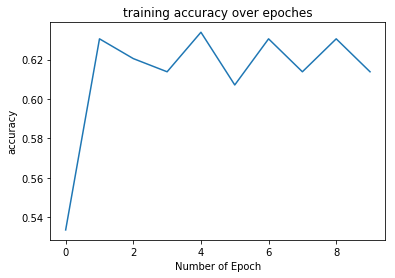

In [155]:
net = Net()
train_accuracy()

In [156]:
test_accuracy()

0.6305803571428571
